In [1]:
!pip install pytorch-fid torch diffusers clip transformers


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

NameError: name 'accelerate' is not defined

In [2]:
!pip install accelerate

In [3]:
from typing import List
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DDPMScheduler


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
def load_model(model_id: str) -> StableDiffusionPipeline:

    return StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    revision="fp16",
    use_auth_token=False
  ).to("cuda")


In [5]:
def generate_images(
    pipe: StableDiffusionPipeline,
    prompts: List[str]
) -> torch.Tensor:
    """Generate images based on provided prompts."""
    with torch.autocast("cuda"):
        images = pipe(prompts).images
    return images

def render_images(images: torch.Tensor):
    """Plot the generated images."""
    plt.figure(figsize=(10, 5))
    for i, img in enumerate(images):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

unet/diffusion_pytorch_model.safetensors not found
Keyword arguments {'use_auth_token': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

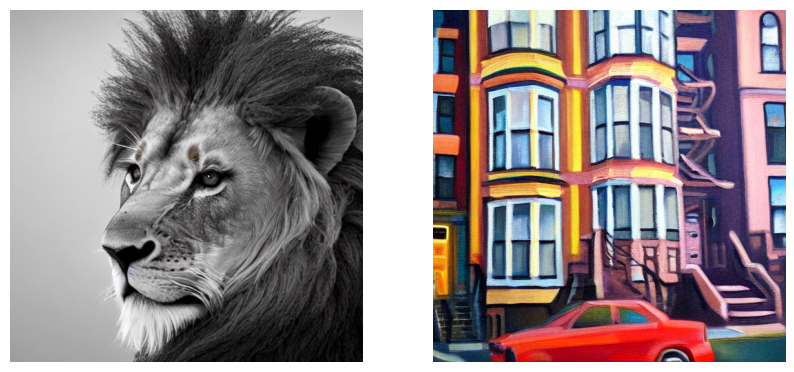

In [8]:
# Execution
model_id = "CompVis/stable-diffusion-v1-4"
prompts = [
"A hyper-realistic photo of a friendly lion",
"A stylized oil painting of a NYC Brownstone"
]
pipe = load_model(model_id)
images = generate_images(pipe, prompts)
render_images(images)


**Evaluation Score**

In [9]:
from typing import List, Tuple
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel


In [10]:
# Constants
CLIP_REPO = "openai/clip-vit-base-patch32"

def load_model_and_processor(
    model_name: str
) -> Tuple[CLIPModel, CLIPProcessor]:
    """
    Loads the CLIP model and processor.
    """
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)
    return model, processor

In [11]:
from typing import List
from transformers import CLIPProcessor
from PIL import Image

def process_inputs(
    processor: CLIPProcessor,
    prompts: List[str],
    images: List[Image.Image]
) -> dict:
    """
    Processes the inputs using the CLIP processor.
    """
    return processor(text=prompts, images=images, return_tensors="pt", padding=True)


In [12]:
from transformers import CLIPModel
import torch

def get_probabilities(
    model: CLIPModel,
    inputs: dict
) -> torch.Tensor:
    """
    Computes the probabilities using the CLIP model.
    """
    outputs = model(**inputs)
    logits = outputs.logits_per_image
    # Define temperature - higher temperature will make the distribution more uniform.
    T = 10
    # Apply temperature to the logits
    temp_adjusted_logits = logits / T
    probs = torch.nn.functional.softmax(temp_adjusted_logits, dim=1)
    return probs


In [13]:
def display_images_with_scores(
    images: List[Image.Image],
    scores: torch.Tensor
) -> None:
    """
    Displays the images alongside their scores.
    """
    # Set print options for readability
    torch.set_printoptions(precision=2, sci_mode=False)
    for i, image in enumerate(images):
        print(f"Image {i + 1}:")
        display(image)
        print(f"Scores: {scores[i, :]}")
        print()

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Image 1:


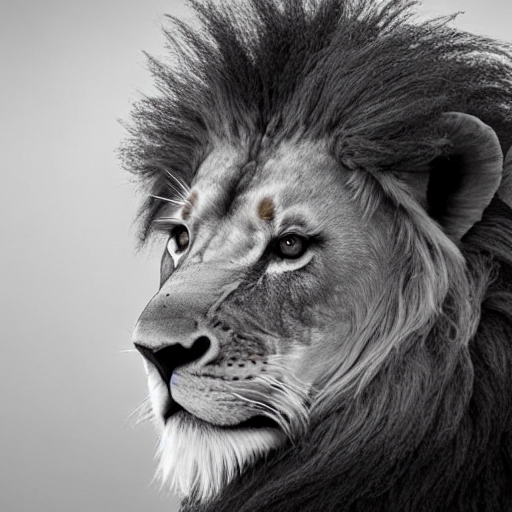

Scores: tensor([0.80, 0.20], grad_fn=<SliceBackward0>)

Image 2:


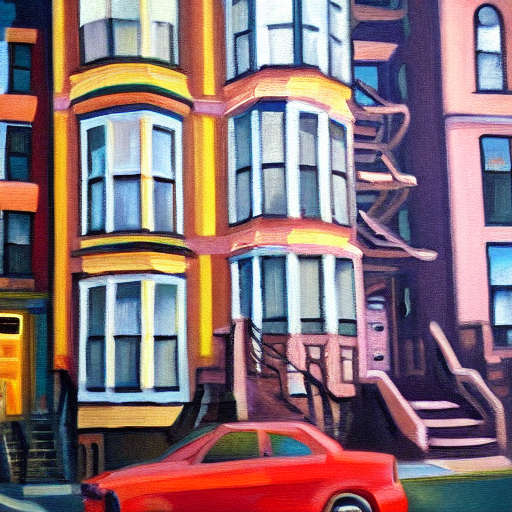

Scores: tensor([0.15, 0.85], grad_fn=<SliceBackward0>)



In [14]:
# Load CLIP model
model, processor = load_model_and_processor(CLIP_REPO)
# Process image and text inputs together
inputs = process_inputs(processor, prompts, images)
# Extract the probabilities
probs = get_probabilities(model, inputs)
# Display each image with corresponding scores
display_images_with_scores(images, probs)
